# Credit Card Analytics 💳

Welcome to our credit card analytics notebook! Here we'll be using Atoti to analyze `5` million records worth of credit card sales transactions, joined together with a rich data model of users, loans, and retailer attributes. Let's see what insights we can generate!

> In this Notebook:
>
> * [1. Import Libraries](#1.-Import-Libraries)
> * [2. Instantiate Atoti Server and Link UI](#2.-Instantiate-Atoti-Server-and-Link-UI)
> * [3. Load CSVs from S3 Into Atoti Tables](#3.-Load-CSVs-from-S3-Into-Atoti-Tables)
> * [4. Join Tables and Create Cube](#4.-Join-Tables-and-Create-Cube)
> * [5. Analyze the Atoti Cube](#5.-Analyze-the-Atoti-Cube)
> * [6. Enrich the Atoti Cube](#6.-Enrich-the-Atoti-Cube)
> * [7. View Dashboards](#7.-View-Dashboards)

**💡 Note:** Our credit card datasets come from [Kaggle](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions/data), feel free to check it out!

[![starting-banner](img/starting-banner.png)](https://www.atoti.io/?utm_source=gallery&utm_content=credit-card-analytics)

## 1. Import Libraries

First things first, let's import our libraries.

In [1]:
import atoti as tt
import pandas as pd
import time
from pprint import pprint

## 2. Instantiate Atoti Server and Link UI

Next, we'll spin up the Atoti server and link the session to our web-based Atoti UI.

💡 **Note**: https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session

In [2]:
# Create a Session object with corresponding parameters set
session = tt.Session(
    user_content_storage="./content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"],
)
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

## 3. Load CSVs from S3 Into Atoti Tables 

From here on, we'll be loading the following CSVs from S3 into Atoti Tables:

* [Credit Card Transaction Data](#Credit-Card-Transaction-Data)
* [Credit Card Info Data](#Credit-Card-Info-Data)
* [User Data](#User-Data)
* [Retailer Data](#Retailer-Data)
* [Loan Data](#Loans-Data)

💡 **Note:** We should be mindful of the (numerical) columns that we intend to use as hierarchies instead of measures (e.g. a User ID does not need to be aggregated!). For this reason, we can explicitly set specific Atoti Table columns as desired data types when loading data into Atoti Tables. See https://docs.atoti.io/latest/api/atoti.Session.read_csv.html#atoti.Session.read_csv for more info.

### Credit Card Transaction Data

Here we use the `read_csv` function to simultaneously load our credit card transaction data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter and set the `date_patterns` parameter to account for our `Datetime` column. All other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [3]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
cc_sales_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/credit_card_transactions_processed_5MM.csv.gz",
    table_name="Sales Transactions",
    types={
        "Datetime": tt.type.LOCAL_DATE_TIME,
        "User": tt.type.STRING,
        "Card": tt.type.STRING,
        "Merchant Name": tt.type.STRING,
        "Zip": tt.type.STRING,
        "MCC": tt.type.STRING,
    },
    date_patterns={"Datetime": "yyyy-MM-dd HH:mm:ss"},
)
cc_sales_table.head()

,User,Card,Datetime,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,1158,1,2013-05-29 21:08:00,-12.6,Swipe Transaction,Merchant 57154,Aurora,CO,80013.0,5812,N/A,No
1,50,0,2019-12-17 23:56:00,-3.818,Chip Transaction,Merchant 48650,Whittaker,MI,48190.0,5921,N/A,No
2,1765,0,2014-03-03 02:19:00,1.608,Swipe Transaction,Merchant 13083,Chilton,WI,53014.0,5921,N/A,No
3,1765,0,2014-03-14 02:12:00,2.108,Swipe Transaction,Merchant 13083,Chilton,WI,53014.0,5921,N/A,No
4,1765,0,2014-03-31 02:14:00,-1.926,Swipe Transaction,Merchant 13083,Chilton,WI,53014.0,5921,N/A,No


### Credit Card Info Data

Here we use the `read_csv` function to simultaneously load our credit card info data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter, while all other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [4]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
user_cc_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/cards_processed.csv",
    table_name="User Credit Cards",
    types={
        "User": tt.type.STRING,
        "Card": tt.type.STRING,
        "Retailer ID": tt.type.STRING,
        "Card Number": tt.type.STRING,
        "CVV": tt.type.STRING,
    },
)
user_cc_table.head()

,User,Card,Retailer ID,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,333,1,24,4045887901142827,07/2013,54,YES,2,74968,02/2010,2010,No
1,0,2,26,4582313478255491,02/2024,719,YES,2,96414,07/2003,2004,No
2,335,0,11,5927769013167971,12/2006,774,YES,2,59609,07/2006,2008,No
3,1,3,17,5711382187309326,11/2020,722,YES,2,50054,06/2010,2015,No
4,1,4,18,5766121508358701,02/2023,908,YES,1,50099,07/2006,2012,No


### User Data

Here we use the `read_csv` function to simultaneously load our user data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter, while all other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [5]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
users_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/users_processed.csv",
    table_name="Users",
    types={
        "User": tt.type.STRING,
        "Birth Month": tt.type.STRING,
        "Zipcode": tt.type.STRING,
        "FICO Score": tt.type.STRING,
        "Current Age": tt.type.STRING,
        "Age Range": tt.type.STRING,
        "Retirement Age": tt.type.STRING,
    },
)
users_table.head()

,User,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,...,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,EAD,PD12,PDLT,LGD,Age Range,Income Range
0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,<NA>,La Verne,...,59696,127613,787,5,7543.452009,0.102502,0.148166,0.608904,50-59,50K - 80K
1,214,Eva Roman,28,59,1991,12,Female,7087 Plum Street,<NA>,Saint Petersburg,...,53984,76118,701,1,8943.9972,0.105292,0.150311,0.602701,20-29,50K - 80K
2,1204,Adan Howard,56,66,1963,3,Male,5651 North Boulevard,<NA>,Greenbelt,...,53966,135478,747,1,8464.472055,0.11177,0.160263,0.606199,50-59,50K - 80K
3,1788,Milan Faraday,66,63,1953,6,Male,5807 Lincoln Street,5.0,Warner Robins,...,28104,12054,751,3,8418.794592,0.119991,0.163389,0.610455,60+,20K - 50K
4,1758,Elian Fernandez,32,67,1987,8,Male,3525 Second Lane,<NA>,Lynwood,...,27795,72318,701,4,8943.9972,0.105292,0.150311,0.602701,30-39,20K - 50K


### Retailer Data

Here we use the `read_csv` function to simultaneously load our retailer data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter, while all other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [6]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
cc_info_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/retailers.csv",
    table_name="Credit Card Info",
    types={
        "Retailer ID": tt.type.STRING,
    },
)
cc_info_table.head()

,Retailer ID,Retailer Name,Card Brand,Card Type,Level 1,Level 2,Level 3,Level 4,Level 5,Industry
0,1,Cathay Pacific Elite,Amex,Credit,Bank Corp,Consumer Banking,Cards Business,Travel,Airline,Airline
1,2,Hilton Honors,Amex,Credit,Bank Corp,Consumer Banking,Cards Business,Travel,Hotel,Hotel
2,9,Banana Republic,Mastercard,Credit,Bank Corp,Consumer Banking,Cards Business,Retail,Consumer Discretionary,Fashion
3,12,Venmo,Mastercard,Debit,Bank Corp,Consumer Banking,Cards Business,Financials,Cards & Banking,Cards & Banking
4,28,Chase,Visa,Debit,Bank Corp,Consumer Banking,Cards Business,Financials,Cards & Banking,Cards & Banking


### FICO Data

Here we use the `read_csv` function to simulatenously load our FICO data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter, while all other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [7]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
fico_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/fico.csv",
    table_name="FICO",
    types={"FICO Score": tt.type.STRING},
)
fico_table.head()

,FICO Score,FICO Level,FICO Range
0,300,Poor,300-579
1,328,Poor,300-579
2,331,Poor,300-579
3,349,Poor,300-579
4,350,Poor,300-579


### Loans Data

Here we use the `read_csv` function to simultaneously load our loans data and create a corresponding Atoti Table. We explicitly define column data types with the `types` parameter, while all other columns and their data types for the loaded dataset are automatically inferred via the `read_csv` function.

In [8]:
# Use the `read_csv` function to read CSV from S3 into an Atoti Table
user_loans_table = session.read_csv(
    "s3://data.atoti.io/notebooks/retail-banking/data/loans.csv",
    types={
        "User": tt.type.STRING,
        "Inq Last 6mos": tt.type.STRING,
        "Delinq 2yrs": tt.type.STRING,
        "Public Record": tt.type.STRING,
        "Not Fully Paid": tt.type.STRING,
    },
    table_name="loans",
)
user_loans_table.head()

,User,Credit Policty,Loan Purpose,Interest Rate,Installment,DTI,Days with Credit Line,Revolving Bal,Revol_Util,Inq Last 6mos,Delinq 2yrs,Public Record,Not Fully Paid
0,1905,0,Debt Consolidation,0.1786,72.17,28.73,4709.0,6076,79.9,6,1,0,0
1,1906,0,All Other,0.128,100.8,3.42,3330.0,296,74.0,3,0,1,0
2,1909,0,Major Purchase,0.1343,67.81,8.75,419.0,1615,54.1,8,0,1,0
3,1922,0,All Other,0.1343,27.13,0.0,540.041667,0,0.0,2,0,0,1
4,1923,1,Debt Consolidation,0.1461,689.51,22.55,5699.958333,25920,36.8,0,2,0,0


## 4. Join Tables and Create Cube

Now, that our data is loaded into our Atoti Tables and in the format that we want, we should join our tables together on common keys to extend attributes from other entity relationships, and create our Atoti cube.

In [9]:
# Join tables
cc_sales_table.join(
    user_cc_table,
    (cc_sales_table["User"] == user_cc_table["User"])
    & (cc_sales_table["Card"] == user_cc_table["Card"]),
)
cc_sales_table.join(users_table, cc_sales_table["User"] == users_table["User"])
users_table.join(fico_table, users_table["FICO Score"] == fico_table["FICO Score"])
user_cc_table.join(
    cc_info_table, user_cc_table["Retailer ID"] == cc_info_table["Retailer ID"]
)
users_table.join(user_loans_table, users_table["User"] == user_loans_table["User"])

In [10]:
# Create Cube from Atoti Table object
cube = session.create_cube(cc_sales_table)

## 5. Analyze the Atoti Cube

Now that the data has been loaded into the cube, we'll want to examine the data model of the cube to confirm that the columns and data types match up to what we expect. In addition, we can view the hierarchies, levels, and measures for our cube by assigning them to variables.

💡 **Note:** https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Multidimensional-concepts

In [11]:
# View the schema of the data model
session.tables.schema

```mermaid
erDiagram
  "Sales Transactions" {
    _ String "User"
    _ String "Card"
    _ LocalDateTime "Datetime"
    nullable double "Amount"
    _ String "Use Chip"
    _ String "Merchant Name"
    _ String "Merchant City"
    _ String "Merchant State"
    _ String "Zip"
    _ String "MCC"
    _ String "Errors?"
    _ String "Is Fraud?"
  }
  "User Credit Cards" {
    _ String "User"
    _ String "Card"
    _ String "Retailer ID"
    _ String "Card Number"
    _ String "Expires"
    _ String "CVV"
    _ String "Has Chip"
    nullable int "Cards Issued"
    nullable int "Credit Limit"
    _ String "Acct Open Date"
    nullable int "Year PIN last Changed"
    _ String "Card on Dark Web"
  }
  "loans" {
    _ String "User"
    nullable int "Credit Policty"
    _ String "Loan Purpose"
    nullable double "Interest Rate"
    nullable double "Installment"
    nullable double "DTI"
    nullable double "Days with Credit Line"
    nullable int "Revolving Bal"
    nullable double "Revol_Util"
    _ String "Inq Last 6mos"
    _ String "Delinq 2yrs"
    _ String "Public Record"
    _ String "Not Fully Paid"
  }
  "Users" {
    _ String "User"
    _ String "Person"
    _ String "Current Age"
    _ String "Retirement Age"
    nullable int "Birth Year"
    _ String "Birth Month"
    _ String "Gender"
    _ String "Address"
    nullable double "Apartment"
    _ String "City"
    _ String "State"
    _ String "Zipcode"
    nullable double "Latitude"
    nullable double "Longitude"
    nullable int "Per Capita Income - Zipcode"
    nullable int "Yearly Income - Person"
    nullable int "Total Debt"
    _ String "FICO Score"
    nullable int "Num Credit Cards"
    nullable double "EAD"
    nullable double "PD12"
    nullable double "PDLT"
    nullable double "LGD"
    _ String "Age Range"
    _ String "Income Range"
  }
  "Credit Card Info" {
    _ String "Retailer ID"
    _ String "Retailer Name"
    _ String "Card Brand"
    _ String "Card Type"
    _ String "Level 1"
    _ String "Level 2"
    _ String "Level 3"
    _ String "Level 4"
    _ String "Level 5"
    _ String "Industry"
  }
  "FICO" {
    _ String "FICO Score"
    _ String "FICO Level"
    _ String "FICO Range"
  }
  "Sales Transactions" }o--o| "User Credit Cards" : "(`Card` == `Card`) & (`User` == `User`)"
  "Sales Transactions" }o--o| "Users" : "`User` == `User`"
  "User Credit Cards" }o--o| "Credit Card Info" : "`Retailer ID` == `Retailer ID`"
  "Users" }o--o| "loans" : "`User` == `User`"
  "Users" }o--o| "FICO" : "`FICO Score` == `FICO Score`"
```


In [12]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

## 6. Enrich the Atoti Cube

Based on our analysis, there are a few aspects that we can do to enrich our cube, namely creating multi-level hierarchies, adjusting the ordering for particlar levels, and creating new measures.

* [Create Multi-Level Hierarchies](#Create-Multi-Level-Hierarchies)
* [Adjust Level Ordering](#Adjust-Level-Ordering)
* [Create New Measures](#Create-New-Measures)
* [Validate Measures](#Validate-Measures)
* [Create Credit Risk Measures](#Create-Credit-Risk-Measures)

### Create Multi-Level Hierarchies

Here we'll create a multi-level date hierarchy that allows us to break down our `Datetime` column into multiple levels. This allows us to drill-down from the top-level (in this case `Year`) to each underlying level, and see the breakdown of how each underlying level contributes to the overall measure aggregation. In addition, this also gives us more granularity in how we aggregate our measures, as we can specify the `OriginScope` which defines the level at which we perform our aggregations when creating new measures.

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.Cube.create_date_hierarchy.html#atoti.Cube.create_date_hierarchy
* https://docs.atoti.io/latest/api/atoti.OriginScope.html#atoti.OriginScope

In [13]:
# Create a multi-level date hierarchy
cube.create_date_hierarchy(
    "Transaction Date",
    column=cc_sales_table["Datetime"],
    levels={
        "Year": "yyyy",
        "Quarter": "QQQ",
        "Month": "MMM",
        "Day": "dd",
        "Hour": "HH",
    },
)

# Create multi-level hierarchy and clean up corresponding single-level hierarchies
h["Retailer Levels"] = [
    l["Level 1"],
    l["Level 2"],
    l["Level 3"],
    l["Level 4"],
    l["Level 5"],
]
del h["Level 1"]
del h["Level 2"]
del h["Level 3"]
del h["Level 4"]
del h["Level 5"]

### Adjust Level Ordering

In addition, we can use `CustomOrder` to customize the order of values for a specified level.

💡 **Note:** https://docs.atoti.io/latest/api/atoti.CustomOrder.html#atoti.CustomOrder

In [14]:
# Set Income Range level ordering as a user-defined CustomOrder
l["Income Range"].order = tt.CustomOrder(
    first_elements=[
        "0K - 20K",
        "20K - 50K",
        "50K - 80K",
        "80K - 100K",
        "100K - 150K",
        "150K - 200K",
        "200K+",
    ]
)

# Set FICO level ordering as a user-defined CustomOrder
l["FICO Level"].order = tt.CustomOrder(
    first_elements=["Poor", "Fair", "Good", "Very Good", "Exceptional"]
)

### Create New Measures

Now, let's create some new measures! For this part, we'll be creating measures relating to user credit (credit cards) and debt (loans). Overall, we'll be showcasing a number of different aggregate functions, so feel free to check out the associated documentation as needed.

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.agg.count_distinct.html#atoti.agg.count_distinct
* https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value
* https://docs.atoti.io/latest/api/atoti.agg.sum.html#atoti.agg.sum
* https://docs.atoti.io/latest/api/atoti.OriginScope.html#atoti.OriginScope



In [15]:
# Create count distinct measure
m["Num Credit Cards"] = tt.agg.count_distinct(user_cc_table["Card Number"])

# Create single value measures
m["Income Annual"] = tt.agg.single_value(users_table["Yearly Income - Person"])
m["Interest Rate"] = tt.agg.single_value(user_loans_table["Interest Rate"])
m["Days with Credit Line"] = tt.agg.single_value(
    user_loans_table["Days with Credit Line"]
)
m["Total Debt.SV"] = tt.agg.single_value(users_table["Total Debt"])
m["Credit_Limit.SV"] = tt.agg.single_value(user_cc_table["Credit Limit"])
m["Revolving Balance.SV"] = tt.agg.single_value(user_loans_table["Revolving Bal"])
m["Revolving Utilization.SV"] = tt.agg.single_value(user_loans_table["Revol_Util"])

# Create measures and define aggregation scope (as needed)
m["Amount"] = tt.agg.sum(cc_sales_table["Amount"])
m["Total Debt"] = tt.agg.sum(
    m["Total Debt.SV"],
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)
m["Credit Limit"] = tt.agg.sum(
    m["Credit_Limit.SV"], scope=tt.OriginScope(l["Card Number"])
)
m["Revolving Balance"] = tt.agg.sum(
    m["Revolving Balance.SV"],
    scope=tt.OriginScope(l["User"]),
)
m["Revolving Utilization"] = tt.agg.sum(
    m["Revolving Utilization.SV"],
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)

# Create measures from other calculated measures
m["Utilization"] = m["Amount"] / m["Credit Limit"]
m["Utilization"].formatter = "DOUBLE[0.00%]"

### Validate Measures

We can then take a look at our newly created measures to validate that they are indeed working properly. Take a look at the underlying values to validate the measure calculations/aggregations.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
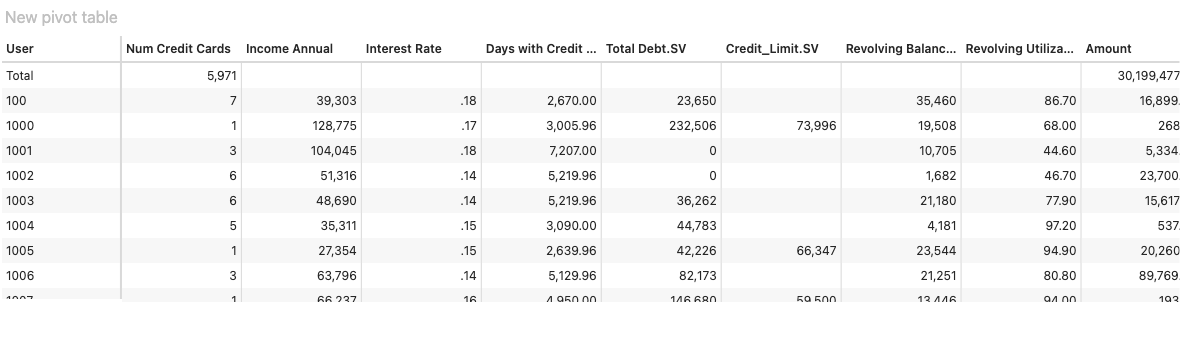

In [16]:
session.widget

### Create Credit Risk Measures


Lastly, we'll create new credit risk measures and calculate the expected credit loss for each user.

$$ ECL = EAD * PD * LGD $$

Where...
* ECL = Expected credit losses
* EAD = Exposure at default
* PD = Probability of default
* LGD = Loss given default

💡 **Note:** 

* https://docs.atoti.io/latest/api/atoti.agg.mean.html#atoti.agg.mean
* https://docs.atoti.io/latest/api/atoti.agg.sum_product.html#atoti.agg.sum_product

In [17]:
# Create new credit risk measures
m["PD12"] = tt.agg.mean(
    tt.agg.single_value(users_table["PD12"]),
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)
m["PDLT"] = tt.agg.mean(
    tt.agg.single_value(users_table["PDLT"]),
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)
m["LGD"] = tt.agg.mean(
    tt.agg.single_value(users_table["LGD"]),
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)
m["EAD"] = m["Amount"]
m["ECL"] = tt.agg.sum_product(
    m["Amount"],
    m["LGD"],
    m["PD12"],
    scope=tt.OriginScope(l[("Sales Transactions", "User", "User")]),
)

# Format our measures as percentages
m["PD12"].formatter = "DOUBLE[0.00%]"
m["PDLT"].formatter = "DOUBLE[0.00%]"
m["LGD"].formatter = "DOUBLE[0.00%]"

# Categorize our measures
m["PD12"].folder = "Credit Risk"
m["PDLT"].folder = "Credit Risk"
m["LGD"].folder = "Credit Risk"
m["EAD"].folder = "Credit Risk"
m["ECL"].folder = "Credit Risk"

## 7. View Dashboards

With our cube fully set up and ready-to-go, let's now create our visualizations via slicing-and-dicing. We'll create dashboards for the following categories:

* [Overview](#Overview-Dashboard)
* [Customers](#Customers-Dashboard)
* [Retailers](#Retailers-Dashboard)
* [Transactions](#Transactions-Dashboard)

### Overview Dashboard

View overall credit risk, distribution of loan types, credit card exposure, etc.

In [18]:
# Use `session.link` to link to Overview Dashboard
session.link / "#/dashboard/935"

http://localhost:9092/#/dashboard/935

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Customers Dashboard

View customer credit risk, loan types, credit card exposure, etc. 

In [19]:
# Use `session.link` to link to Customers Dashboard
session.link / "#/dashboard/38c"

http://localhost:9092/#/dashboard/38c

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Retailers Dashboard

View retailer exposure by industry.

In [20]:
# Use `session.link` to link to Retailers Dashboard
session.link / "#/dashboard/3c2"

http://localhost:9092/#/dashboard/3c2

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

### Transactions Dashboard

View transactions by customer name, retailers, transaction year, or transaction city.

In [21]:
# Use `session.link` to link to Transactions Dashboard
session.link / "#/dashboard/85d"

http://localhost:9092/#/dashboard/85d

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

[![ending-banner](img/ending-banner.png)](https://www.atoti.io/?utm_source=gallery&utm_content=credit-card-analytics)